##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
print(tf.__version__)

2.3.1


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 3:18

   73728/84125825 [..............................] - ETA: 1:29

  155648/84125825 [..............................] - ETA: 1:14

  335872/84125825 [..............................] - ETA: 48s 

  712704/84125825 [..............................] - ETA: 29s

 1482752/84125825 [..............................] - ETA: 17s

 2908160/84125825 [>.............................] - ETA: 10s

 5283840/84125825 [>.............................] - ETA: 6s 

 7561216/84125825 [=>............................] - ETA: 4s

10330112/84125825 [==>...........................] - ETA: 3s

13492224/84125825 [===>..........................] - ETA: 3s

16867328/84125825 [=====>........................] - ETA: 2s

20439040/84125825 [======>.......................] - ETA: 2s

23699456/84125825 [=======>......................] - ETA: 1s

26902528/84125825 [========>.....................] - ETA: 1s

30203904/84125825 [=========>....................] - ETA: 1s

33824768/84125825 [===========>..................] - ETA: 1s

37093376/84125825 [============>.................] - ETA: 1s

40230912/84125825 [=============>................] - ETA: 1s

43622400/84125825 [==============>...............] - ETA: 0s

47177728/84125825 [===============>..............] - ETA: 0s

50896896/84125825 [=================>............] - ETA: 0s

54059008/84125825 [==================>...........] - ETA: 0s

57597952/84125825 [===================>..........] - ETA: 0s

61104128/84125825 [====================>.........] - ETA: 0s

64708608/84125825 [======================>.......]

 - ETA: 0s

68083712/84125825 [=======================>......] - ETA: 0s

71360512/84125825 [========================>.....] - ETA: 0s

74391552/84125825 [=========================>....] - ETA: 0s

77832192/84125825 [==========================>...] - ETA: 0s

81190912/84125825 [===========================>..] - ETA: 0s

84131840/84125825 [==============================] - 2s 0us/step


In [6]:
os.listdir(dataset_dir)

['train', 'test', 'README', 'imdb.vocab', 'imdbEr.txt']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'unsupBow.feat',
 'urls_neg.txt',
 'pos',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_unsup.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 0s - loss: 0.6946 - binary_accuracy: 0.4062

 10/625 [..............................] - ETA: 3s - loss: 0.6934 - binary_accuracy: 0.4844

 22/625 [>.............................] - ETA: 2s - loss: 0.6930 - binary_accuracy: 0.5213

 34/625 [>.............................] - ETA: 2s - loss: 0.6929 - binary_accuracy: 0.5175

 45/625 [=>............................] - ETA: 2s - loss: 0.6927 - binary_accuracy: 0.5194

 57/625 [=>............................] - ETA: 2s - loss: 0.6923 - binary_accuracy: 0.5340

 69/625 [==>...........................] - ETA: 2s - loss: 0.6922 - binary_accuracy: 0.5281

 81/625 [==>...........................] - ETA: 2s - loss: 0.6919 - binary_accuracy: 0.5293

 94/625 [===>..........................] - ETA: 2s - loss: 0.6918 - binary_accuracy: 0.5239

105/625 [====>.........................] - ETA: 2s - loss: 0.6917 - binary_accuracy: 0.5185

117/625 [====>.........................] - ETA: 2s - loss: 0.6916 - binary_accuracy: 0.5211

129/625 [=====>........................] - ETA: 2s - loss: 0.6914 - binary_accuracy: 0.5354

141/625 [=====>........................] - ETA: 2s - loss: 0.6912 - binary_accuracy: 0.5450

153/625 [======>.......................] - ETA: 2s - loss: 0.6910 - binary_accuracy: 0.5588

164/625 [======>.......................] - ETA: 2s - loss: 0.6907 - binary_accuracy: 0.5676

176/625 [=======>......................] - ETA: 2s - loss: 0.6904 - binary_accuracy: 0.5753

188/625 [========>.....................] - ETA: 1s - loss: 0.6901 - binary_accuracy: 0.5805

200/625 [========>.....................] - ETA: 1s - loss: 0.6898 - binary_accuracy: 0.5814

212/625 [=========>....................] - ETA: 1s - loss: 0.6896 - binary_accuracy: 0.5834

224/625 [=========>....................] - ETA: 1s - loss: 0.6892 - binary_accuracy: 0.5890

236/625 [==========>...................] - ETA: 1s - loss: 0.6887 - binary_accuracy: 0.5956

246/625 [==========>...................] - ETA: 1s - loss: 0.6884 - binary_accuracy: 0.5998

256/625 [===========>..................] - ETA: 1s - loss: 0.6879 - binary_accuracy: 0.6034

268/625 [===========>..................] - ETA: 1s - loss: 0.6874 - binary_accuracy: 0.6073

279/625 [============>.................] - ETA: 1s - loss: 0.6869 - binary_accuracy: 0.6104

291/625 [============>.................] - ETA: 1s - loss: 0.6866 - binary_accuracy: 0.6136

303/625 [=============>................] - ETA: 1s - loss: 0.6862 - binary_accuracy: 0.6175

314/625 [==============>...............] - ETA: 1s - loss: 0.6857 - binary_accuracy: 0.6193

324/625 [==============>...............] - ETA: 1s - loss: 0.6853 - binary_accuracy: 0.6217

335/625 [===============>..............] - ETA: 1s - loss: 0.6849 - binary_accuracy: 0.6231

344/625 [===============>..............] - ETA: 1s - loss: 0.6845 - binary_accuracy: 0.6265

356/625 [================>.............] - ETA: 1s - loss: 0.6839 - binary_accuracy: 0.6290

368/625 [================>.............] - ETA: 1s - loss: 0.6831 - binary_accuracy: 0.6330

379/625 [=================>............] - ETA: 1s - loss: 0.6825 - binary_accuracy: 0.6361

389/625 [=================>............] - ETA: 1s - loss: 0.6819 - binary_accuracy: 0.6398

401/625 [==================>...........] - ETA: 1s - loss: 0.6812 - binary_accuracy: 0.6430

413/625 [==================>...........] - ETA: 0s - loss: 0.6805 - binary_accuracy: 0.6463

424/625 [===================>..........] - ETA: 0s - loss: 0.6797 - binary_accuracy: 0.6498

435/625 [===================>..........] - ETA: 0s - loss: 0.6790 - binary_accuracy: 0.6525

447/625 [====================>.........] - ETA: 0s - loss: 0.6784 - binary_accuracy: 0.6548

459/625 [=====================>........] - ETA: 0s - loss: 0.6776 - binary_accuracy: 0.6573

471/625 [=====================>........] - ETA: 0s - loss: 0.6769 - binary_accuracy: 0.6589

482/625 [======================>.......] - ETA: 0s - loss: 0.6762 - binary_accuracy: 0.6606

494/625 [======================>.......] - ETA: 0s - loss: 0.6753 - binary_accuracy: 0.6633

505/625 [=======================>......] - ETA: 0s - loss: 0.6744 - binary_accuracy: 0.6663

517/625 [=======================>......] - ETA: 0s - loss: 0.6736 - binary_accuracy: 0.6680

529/625 [========================>.....] - ETA: 0s - loss: 0.6726 - binary_accuracy: 0.6710

541/625 [========================>.....] - ETA: 0s - loss: 0.6717 - binary_accuracy: 0.6725

553/625 [=========================>....] - ETA: 0s - loss: 0.6710 - binary_accuracy: 0.6738

564/625 [==========================>...] - ETA: 0s - loss: 0.6699 - binary_accuracy: 0.6754

575/625 [==========================>...] - ETA: 0s - loss: 0.6691 - binary_accuracy: 0.6770

587/625 [===========================>..] - ETA: 0s - loss: 0.6682 - binary_accuracy: 0.6790

598/625 [===========================>..] - ETA: 0s - loss: 0.6673 - binary_accuracy: 0.6809

610/625 [============================>.] - ETA: 0s - loss: 0.6663 - binary_accuracy: 0.6825

621/625 [============================>.] - ETA: 0s - loss: 0.6656 - binary_accuracy: 0.6840

625/625 [==============================] - 4s 6ms/step - loss: 0.6653 - binary_accuracy: 0.6843 - val_loss: 0.6151 - val_binary_accuracy: 0.7706


Epoch 2/10
  1/625 [..............................] - ETA: 0s - loss: 0.6184 - binary_accuracy: 0.7500

 13/625 [..............................] - ETA: 2s - loss: 0.6064 - binary_accuracy: 0.7861

 26/625 [>.............................] - ETA: 2s - loss: 0.6131 - binary_accuracy: 0.7644

 40/625 [>.............................] - ETA: 2s - loss: 0.6113 - binary_accuracy: 0.7625

 53/625 [=>............................] - ETA: 2s - loss: 0.6065 - binary_accuracy: 0.7718

 66/625 [==>...........................] - ETA: 2s - loss: 0.6060 - binary_accuracy: 0.7699

 79/625 [==>...........................] - ETA: 2s - loss: 0.6053 - binary_accuracy: 0.7702

 93/625 [===>..........................] - ETA: 2s - loss: 0.6044 - binary_accuracy: 0.7705

105/625 [====>.........................] - ETA: 2s - loss: 0.6014 - binary_accuracy: 0.7744

118/625 [====>.........................] - ETA: 1s - loss: 0.6012 - binary_accuracy: 0.7717

131/625 [=====>........................] - ETA: 1s - loss: 0.6001 - binary_accuracy: 0.7705

144/625 [=====>........................] - ETA: 1s - loss: 0.5983 - binary_accuracy: 0.7717

157/625 [======>.......................] - ETA: 1s - loss: 0.5973 - binary_accuracy: 0.7719

170/625 [=======>......................] - ETA: 1s - loss: 0.5964 - binary_accuracy: 0.7721

183/625 [=======>......................] - ETA: 1s - loss: 0.5946 - binary_accuracy: 0.7734

196/625 [========>.....................] - ETA: 1s - loss: 0.5934 - binary_accuracy: 0.7738

209/625 [=========>....................] - ETA: 1s - loss: 0.5916 - binary_accuracy: 0.7747

222/625 [=========>....................] - ETA: 1s - loss: 0.5906 - binary_accuracy: 0.7752

235/625 [==========>...................] - ETA: 1s - loss: 0.5887 - binary_accuracy: 0.7765

248/625 [==========>...................] - ETA: 1s - loss: 0.5872 - binary_accuracy: 0.7763

261/625 [===========>..................] - ETA: 1s - loss: 0.5852 - binary_accuracy: 0.7780

274/625 [============>.................] - ETA: 1s - loss: 0.5831 - binary_accuracy: 0.7800

288/625 [============>.................] - ETA: 1s - loss: 0.5822 - binary_accuracy: 0.7806

301/625 [=============>................] - ETA: 1s - loss: 0.5815 - binary_accuracy: 0.7798

314/625 [==============>...............] - ETA: 1s - loss: 0.5806 - binary_accuracy: 0.7792

327/625 [==============>...............] - ETA: 1s - loss: 0.5792 - binary_accuracy: 0.7797

340/625 [===============>..............] - ETA: 1s - loss: 0.5784 - binary_accuracy: 0.7801

353/625 [===============>..............] - ETA: 1s - loss: 0.5766 - binary_accuracy: 0.7820

365/625 [================>.............] - ETA: 1s - loss: 0.5750 - binary_accuracy: 0.7838

378/625 [=================>............] - ETA: 0s - loss: 0.5733 - binary_accuracy: 0.7847

391/625 [=================>............] - ETA: 0s - loss: 0.5717 - binary_accuracy: 0.7864

404/625 [==================>...........] - ETA: 0s - loss: 0.5700 - binary_accuracy: 0.7877

418/625 [===================>..........] - ETA: 0s - loss: 0.5684 - binary_accuracy: 0.7885

431/625 [===================>..........] - ETA: 0s - loss: 0.5669 - binary_accuracy: 0.7892

444/625 [====================>.........] - ETA: 0s - loss: 0.5662 - binary_accuracy: 0.7897

458/625 [====================>.........] - ETA: 0s - loss: 0.5647 - binary_accuracy: 0.7904

471/625 [=====================>........] - ETA: 0s - loss: 0.5635 - binary_accuracy: 0.7909

485/625 [======================>.......] - ETA: 0s - loss: 0.5619 - binary_accuracy: 0.7921

498/625 [======================>.......] - ETA: 0s - loss: 0.5602 - binary_accuracy: 0.7937

511/625 [=======================>......] - ETA: 0s - loss: 0.5590 - binary_accuracy: 0.7942

525/625 [========================>.....] - ETA: 0s - loss: 0.5572 - binary_accuracy: 0.7954

539/625 [========================>.....] - ETA: 0s - loss: 0.5559 - binary_accuracy: 0.7960

553/625 [=========================>....] - ETA: 0s - loss: 0.5549 - binary_accuracy: 0.7964

566/625 [==========================>...] - ETA: 0s - loss: 0.5534 - binary_accuracy: 0.7974

579/625 [==========================>...] - ETA: 0s - loss: 0.5523 - binary_accuracy: 0.7977

592/625 [===========================>..] - ETA: 0s - loss: 0.5510 - binary_accuracy: 0.7986

605/625 [============================>.] - ETA: 0s - loss: 0.5500 - binary_accuracy: 0.7988

618/625 [============================>.] - ETA: 0s - loss: 0.5490 - binary_accuracy: 0.7989

625/625 [==============================] - 3s 4ms/step - loss: 0.5484 - binary_accuracy: 0.7991 - val_loss: 0.4977 - val_binary_accuracy: 0.8216


Epoch 3/10
  1/625 [..............................] - ETA: 0s - loss: 0.4976 - binary_accuracy: 0.8438

 14/625 [..............................] - ETA: 2s - loss: 0.4793 - binary_accuracy: 0.8415

 27/625 [>.............................] - ETA: 2s - loss: 0.4933 - binary_accuracy: 0.8218

 40/625 [>.............................] - ETA: 2s - loss: 0.4864 - binary_accuracy: 0.8273

 53/625 [=>............................] - ETA: 2s - loss: 0.4811 - binary_accuracy: 0.8325

 67/625 [==>...........................] - ETA: 2s - loss: 0.4830 - binary_accuracy: 0.8284

 80/625 [==>...........................] - ETA: 2s - loss: 0.4825 - binary_accuracy: 0.8301

 94/625 [===>..........................] - ETA: 2s - loss: 0.4823 - binary_accuracy: 0.8285

107/625 [====>.........................] - ETA: 2s - loss: 0.4788 - binary_accuracy: 0.8321

120/625 [====>.........................] - ETA: 1s - loss: 0.4786 - binary_accuracy: 0.8313

133/625 [=====>........................] - ETA: 1s - loss: 0.4781 - binary_accuracy: 0.8289

146/625 [======>.......................] - ETA: 1s - loss: 0.4770 - binary_accuracy: 0.8294

158/625 [======>.......................] - ETA: 1s - loss: 0.4775 - binary_accuracy: 0.8277

171/625 [=======>......................] - ETA: 1s - loss: 0.4766 - binary_accuracy: 0.8299

184/625 [=======>......................] - ETA: 1s - loss: 0.4756 - binary_accuracy: 0.8305

197/625 [========>.....................] - ETA: 1s - loss: 0.4743 - binary_accuracy: 0.8314

210/625 [=========>....................] - ETA: 1s - loss: 0.4735 - binary_accuracy: 0.8308

223/625 [=========>....................] - ETA: 1s - loss: 0.4723 - binary_accuracy: 0.8318

236/625 [==========>...................] - ETA: 1s - loss: 0.4704 - binary_accuracy: 0.8325

249/625 [==========>...................] - ETA: 1s - loss: 0.4695 - binary_accuracy: 0.8317

263/625 [===========>..................] - ETA: 1s - loss: 0.4677 - binary_accuracy: 0.8333

276/625 [============>.................] - ETA: 1s - loss: 0.4658 - binary_accuracy: 0.8349

289/625 [============>.................] - ETA: 1s - loss: 0.4661 - binary_accuracy: 0.8342

302/625 [=============>................] - ETA: 1s - loss: 0.4665 - binary_accuracy: 0.8334

315/625 [==============>...............] - ETA: 1s - loss: 0.4668 - binary_accuracy: 0.8323

328/625 [==============>...............] - ETA: 1s - loss: 0.4656 - binary_accuracy: 0.8328

341/625 [===============>..............] - ETA: 1s - loss: 0.4650 - binary_accuracy: 0.8333

354/625 [===============>..............] - ETA: 1s - loss: 0.4635 - binary_accuracy: 0.8347

365/625 [================>.............] - ETA: 1s - loss: 0.4621 - binary_accuracy: 0.8359

377/625 [=================>............] - ETA: 0s - loss: 0.4608 - binary_accuracy: 0.8364

390/625 [=================>............] - ETA: 0s - loss: 0.4599 - binary_accuracy: 0.8369

404/625 [==================>...........] - ETA: 0s - loss: 0.4585 - binary_accuracy: 0.8373

417/625 [===================>..........] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8381

430/625 [===================>..........] - ETA: 0s - loss: 0.4560 - binary_accuracy: 0.8389

443/625 [====================>.........] - ETA: 0s - loss: 0.4555 - binary_accuracy: 0.8389

456/625 [====================>.........] - ETA: 0s - loss: 0.4548 - binary_accuracy: 0.8392

469/625 [=====================>........] - ETA: 0s - loss: 0.4539 - binary_accuracy: 0.8397

482/625 [======================>.......] - ETA: 0s - loss: 0.4533 - binary_accuracy: 0.8397

495/625 [======================>.......] - ETA: 0s - loss: 0.4517 - binary_accuracy: 0.8406

508/625 [=======================>......] - ETA: 0s - loss: 0.4506 - binary_accuracy: 0.8415

521/625 [========================>.....] - ETA: 0s - loss: 0.4496 - binary_accuracy: 0.8415

533/625 [========================>.....] - ETA: 0s - loss: 0.4484 - binary_accuracy: 0.8425

546/625 [=========================>....] - ETA: 0s - loss: 0.4480 - binary_accuracy: 0.8427

558/625 [=========================>....] - ETA: 0s - loss: 0.4472 - binary_accuracy: 0.8430

570/625 [==========================>...] - ETA: 0s - loss: 0.4465 - binary_accuracy: 0.8430

582/625 [==========================>...] - ETA: 0s - loss: 0.4458 - binary_accuracy: 0.8436

595/625 [===========================>..] - ETA: 0s - loss: 0.4453 - binary_accuracy: 0.8441

606/625 [============================>.] - ETA: 0s - loss: 0.4450 - binary_accuracy: 0.8440

618/625 [============================>.] - ETA: 0s - loss: 0.4446 - binary_accuracy: 0.8440

625/625 [==============================] - 3s 5ms/step - loss: 0.4442 - binary_accuracy: 0.8438 - val_loss: 0.4197 - val_binary_accuracy: 0.8470


Epoch 4/10
  1/625 [..............................] - ETA: 0s - loss: 0.4255 - binary_accuracy: 0.8438

 14/625 [..............................] - ETA: 2s - loss: 0.3941 - binary_accuracy: 0.8638

 27/625 [>.............................] - ETA: 2s - loss: 0.4138 - binary_accuracy: 0.8472

 40/625 [>.............................] - ETA: 2s - loss: 0.4028 - binary_accuracy: 0.8555

 54/625 [=>............................] - ETA: 2s - loss: 0.3998 - binary_accuracy: 0.8588

 67/625 [==>...........................] - ETA: 2s - loss: 0.4017 - binary_accuracy: 0.8591

 80/625 [==>...........................] - ETA: 2s - loss: 0.4026 - binary_accuracy: 0.8582

 94/625 [===>..........................] - ETA: 2s - loss: 0.4039 - binary_accuracy: 0.8561

107/625 [====>.........................] - ETA: 2s - loss: 0.3999 - binary_accuracy: 0.8575

120/625 [====>.........................] - ETA: 1s - loss: 0.3991 - binary_accuracy: 0.8573

133/625 [=====>........................] - ETA: 1s - loss: 0.3993 - binary_accuracy: 0.8543

146/625 [======>.......................] - ETA: 1s - loss: 0.3980 - binary_accuracy: 0.8549

159/625 [======>.......................] - ETA: 1s - loss: 0.3988 - binary_accuracy: 0.8542

173/625 [=======>......................] - ETA: 1s - loss: 0.3981 - binary_accuracy: 0.8553

186/625 [=======>......................] - ETA: 1s - loss: 0.3964 - binary_accuracy: 0.8560

200/625 [========>.....................] - ETA: 1s - loss: 0.3956 - binary_accuracy: 0.8562

213/625 [=========>....................] - ETA: 1s - loss: 0.3962 - binary_accuracy: 0.8564

226/625 [=========>....................] - ETA: 1s - loss: 0.3953 - binary_accuracy: 0.8573

239/625 [==========>...................] - ETA: 1s - loss: 0.3939 - binary_accuracy: 0.8576

249/625 [==========>...................] - ETA: 1s - loss: 0.3936 - binary_accuracy: 0.8573

262/625 [===========>..................] - ETA: 1s - loss: 0.3920 - binary_accuracy: 0.8587

273/625 [============>.................] - ETA: 1s - loss: 0.3906 - binary_accuracy: 0.8594

285/625 [============>.................] - ETA: 1s - loss: 0.3907 - binary_accuracy: 0.8600

298/625 [=============>................] - ETA: 1s - loss: 0.3926 - binary_accuracy: 0.8584

311/625 [=============>................] - ETA: 1s - loss: 0.3927 - binary_accuracy: 0.8573

324/625 [==============>...............] - ETA: 1s - loss: 0.3923 - binary_accuracy: 0.8577

336/625 [===============>..............] - ETA: 1s - loss: 0.3920 - binary_accuracy: 0.8579

350/625 [===============>..............] - ETA: 1s - loss: 0.3903 - binary_accuracy: 0.8591

362/625 [================>.............] - ETA: 1s - loss: 0.3898 - binary_accuracy: 0.8596

375/625 [=================>............] - ETA: 1s - loss: 0.3883 - binary_accuracy: 0.8608

388/625 [=================>............] - ETA: 0s - loss: 0.3874 - binary_accuracy: 0.8615

401/625 [==================>...........] - ETA: 0s - loss: 0.3867 - binary_accuracy: 0.8622

415/625 [==================>...........] - ETA: 0s - loss: 0.3854 - binary_accuracy: 0.8627

429/625 [===================>..........] - ETA: 0s - loss: 0.3844 - binary_accuracy: 0.8631

443/625 [====================>.........] - ETA: 0s - loss: 0.3842 - binary_accuracy: 0.8634

456/625 [====================>.........] - ETA: 0s - loss: 0.3837 - binary_accuracy: 0.8637

469/625 [=====================>........] - ETA: 0s - loss: 0.3833 - binary_accuracy: 0.8643

483/625 [======================>.......] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.8650

497/625 [======================>.......] - ETA: 0s - loss: 0.3811 - binary_accuracy: 0.8661

511/625 [=======================>......] - ETA: 0s - loss: 0.3808 - binary_accuracy: 0.8664

525/625 [========================>.....] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8671

539/625 [========================>.....] - ETA: 0s - loss: 0.3791 - binary_accuracy: 0.8670

552/625 [=========================>....] - ETA: 0s - loss: 0.3791 - binary_accuracy: 0.8670

566/625 [==========================>...] - ETA: 0s - loss: 0.3782 - binary_accuracy: 0.8674

580/625 [==========================>...] - ETA: 0s - loss: 0.3783 - binary_accuracy: 0.8668

594/625 [===========================>..] - ETA: 0s - loss: 0.3778 - binary_accuracy: 0.8670

608/625 [============================>.] - ETA: 0s - loss: 0.3780 - binary_accuracy: 0.8666

622/625 [============================>.] - ETA: 0s - loss: 0.3778 - binary_accuracy: 0.8664

625/625 [==============================] - 3s 4ms/step - loss: 0.3776 - binary_accuracy: 0.8665 - val_loss: 0.3735 - val_binary_accuracy: 0.8602


Epoch 5/10
  1/625 [..............................] - ETA: 0s - loss: 0.3684 - binary_accuracy: 0.8750

 14/625 [..............................] - ETA: 2s - loss: 0.3416 - binary_accuracy: 0.8862

 28/625 [>.............................] - ETA: 2s - loss: 0.3588 - binary_accuracy: 0.8728

 41/625 [>.............................] - ETA: 2s - loss: 0.3477 - binary_accuracy: 0.8834

 54/625 [=>............................] - ETA: 2s - loss: 0.3451 - binary_accuracy: 0.8808

 68/625 [==>...........................] - ETA: 2s - loss: 0.3484 - binary_accuracy: 0.8805

 82/625 [==>...........................] - ETA: 2s - loss: 0.3517 - binary_accuracy: 0.8765

 95/625 [===>..........................] - ETA: 2s - loss: 0.3518 - binary_accuracy: 0.8770

109/625 [====>.........................] - ETA: 1s - loss: 0.3485 - binary_accuracy: 0.8764

123/625 [====>.........................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8755

136/625 [=====>........................] - ETA: 1s - loss: 0.3495 - binary_accuracy: 0.8720

150/625 [======>.......................] - ETA: 1s - loss: 0.3481 - binary_accuracy: 0.8729

164/625 [======>.......................] - ETA: 1s - loss: 0.3507 - binary_accuracy: 0.8702

177/625 [=======>......................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8725

191/625 [========>.....................] - ETA: 1s - loss: 0.3454 - binary_accuracy: 0.8740

205/625 [========>.....................] - ETA: 1s - loss: 0.3457 - binary_accuracy: 0.8738

218/625 [=========>....................] - ETA: 1s - loss: 0.3470 - binary_accuracy: 0.8731

231/625 [==========>...................] - ETA: 1s - loss: 0.3463 - binary_accuracy: 0.8727

245/625 [==========>...................] - ETA: 1s - loss: 0.3456 - binary_accuracy: 0.8726

259/625 [===========>..................] - ETA: 1s - loss: 0.3437 - binary_accuracy: 0.8744

273/625 [============>.................] - ETA: 1s - loss: 0.3428 - binary_accuracy: 0.8749

287/625 [============>.................] - ETA: 1s - loss: 0.3443 - binary_accuracy: 0.8739

300/625 [=============>................] - ETA: 1s - loss: 0.3460 - binary_accuracy: 0.8726

314/625 [==============>...............] - ETA: 1s - loss: 0.3464 - binary_accuracy: 0.8725

328/625 [==============>...............] - ETA: 1s - loss: 0.3455 - binary_accuracy: 0.8727

342/625 [===============>..............] - ETA: 1s - loss: 0.3449 - binary_accuracy: 0.8731

356/625 [================>.............] - ETA: 1s - loss: 0.3437 - binary_accuracy: 0.8739

370/625 [================>.............] - ETA: 0s - loss: 0.3422 - binary_accuracy: 0.8747

384/625 [=================>............] - ETA: 0s - loss: 0.3420 - binary_accuracy: 0.8748

398/625 [==================>...........] - ETA: 0s - loss: 0.3411 - binary_accuracy: 0.8755

411/625 [==================>...........] - ETA: 0s - loss: 0.3398 - binary_accuracy: 0.8764

425/625 [===================>..........] - ETA: 0s - loss: 0.3394 - binary_accuracy: 0.8767

439/625 [====================>.........] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8771

452/625 [====================>.........] - ETA: 0s - loss: 0.3391 - binary_accuracy: 0.8765

466/625 [=====================>........] - ETA: 0s - loss: 0.3381 - binary_accuracy: 0.8771

480/625 [======================>.......] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.8771

494/625 [======================>.......] - ETA: 0s - loss: 0.3371 - binary_accuracy: 0.8782

507/625 [=======================>......] - ETA: 0s - loss: 0.3364 - binary_accuracy: 0.8787

519/625 [=======================>......] - ETA: 0s - loss: 0.3357 - binary_accuracy: 0.8789

533/625 [========================>.....] - ETA: 0s - loss: 0.3351 - binary_accuracy: 0.8791

547/625 [=========================>....] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8790

560/625 [=========================>....] - ETA: 0s - loss: 0.3350 - binary_accuracy: 0.8788

574/625 [==========================>...] - ETA: 0s - loss: 0.3350 - binary_accuracy: 0.8788

587/625 [===========================>..] - ETA: 0s - loss: 0.3351 - binary_accuracy: 0.8787

601/625 [===========================>..] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8792

615/625 [============================>.] - ETA: 0s - loss: 0.3356 - binary_accuracy: 0.8787

625/625 [==============================] - 3s 4ms/step - loss: 0.3355 - binary_accuracy: 0.8784 - val_loss: 0.3449 - val_binary_accuracy: 0.8674


Epoch 6/10
  1/625 [..............................] - ETA: 0s - loss: 0.3449 - binary_accuracy: 0.8750

 15/625 [..............................] - ETA: 2s - loss: 0.3128 - binary_accuracy: 0.8917

 29/625 [>.............................] - ETA: 2s - loss: 0.3228 - binary_accuracy: 0.8858

 43/625 [=>............................] - ETA: 2s - loss: 0.3123 - binary_accuracy: 0.8924

 57/625 [=>............................] - ETA: 2s - loss: 0.3132 - binary_accuracy: 0.8887

 70/625 [==>...........................] - ETA: 2s - loss: 0.3155 - binary_accuracy: 0.8884

 84/625 [===>..........................] - ETA: 2s - loss: 0.3169 - binary_accuracy: 0.8858

 98/625 [===>..........................] - ETA: 1s - loss: 0.3182 - binary_accuracy: 0.8858

111/625 [====>.........................] - ETA: 1s - loss: 0.3162 - binary_accuracy: 0.8863

125/625 [=====>........................] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8863

139/625 [=====>........................] - ETA: 1s - loss: 0.3175 - binary_accuracy: 0.8826

152/625 [======>.......................] - ETA: 1s - loss: 0.3175 - binary_accuracy: 0.8834

166/625 [======>.......................] - ETA: 1s - loss: 0.3181 - binary_accuracy: 0.8818

179/625 [=======>......................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8841

192/625 [========>.....................] - ETA: 1s - loss: 0.3132 - binary_accuracy: 0.8851

206/625 [========>.....................] - ETA: 1s - loss: 0.3142 - binary_accuracy: 0.8847

220/625 [=========>....................] - ETA: 1s - loss: 0.3154 - binary_accuracy: 0.8842

234/625 [==========>...................] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8839

248/625 [==========>...................] - ETA: 1s - loss: 0.3141 - binary_accuracy: 0.8836

262/625 [===========>..................] - ETA: 1s - loss: 0.3128 - binary_accuracy: 0.8853

276/625 [============>.................] - ETA: 1s - loss: 0.3122 - binary_accuracy: 0.8855

290/625 [============>.................] - ETA: 1s - loss: 0.3133 - binary_accuracy: 0.8847

304/625 [=============>................] - ETA: 1s - loss: 0.3147 - binary_accuracy: 0.8831

318/625 [==============>...............] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8827

332/625 [==============>...............] - ETA: 1s - loss: 0.3144 - binary_accuracy: 0.8828

346/625 [===============>..............] - ETA: 1s - loss: 0.3135 - binary_accuracy: 0.8833

359/625 [================>.............] - ETA: 1s - loss: 0.3128 - binary_accuracy: 0.8834

373/625 [================>.............] - ETA: 0s - loss: 0.3107 - binary_accuracy: 0.8846

387/625 [=================>............] - ETA: 0s - loss: 0.3101 - binary_accuracy: 0.8849

400/625 [==================>...........] - ETA: 0s - loss: 0.3100 - binary_accuracy: 0.8849

414/625 [==================>...........] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8853

428/625 [===================>..........] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.8858

442/625 [====================>.........] - ETA: 0s - loss: 0.3083 - binary_accuracy: 0.8857

456/625 [====================>.........] - ETA: 0s - loss: 0.3082 - binary_accuracy: 0.8859

470/625 [=====================>........] - ETA: 0s - loss: 0.3080 - binary_accuracy: 0.8860

484/625 [======================>.......] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8866

498/625 [======================>.......] - ETA: 0s - loss: 0.3065 - binary_accuracy: 0.8871

512/625 [=======================>......] - ETA: 0s - loss: 0.3060 - binary_accuracy: 0.8876

526/625 [========================>.....] - ETA: 0s - loss: 0.3050 - binary_accuracy: 0.8875

540/625 [========================>.....] - ETA: 0s - loss: 0.3057 - binary_accuracy: 0.8873

554/625 [=========================>....] - ETA: 0s - loss: 0.3057 - binary_accuracy: 0.8872

567/625 [==========================>...] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.8875

581/625 [==========================>...] - ETA: 0s - loss: 0.3054 - binary_accuracy: 0.8872

595/625 [===========================>..] - ETA: 0s - loss: 0.3058 - binary_accuracy: 0.8874

609/625 [============================>.] - ETA: 0s - loss: 0.3063 - binary_accuracy: 0.8873

622/625 [============================>.] - ETA: 0s - loss: 0.3064 - binary_accuracy: 0.8869

625/625 [==============================] - 3s 4ms/step - loss: 0.3062 - binary_accuracy: 0.8870 - val_loss: 0.3261 - val_binary_accuracy: 0.8712


Epoch 7/10
  1/625 [..............................] - ETA: 0s - loss: 0.3235 - binary_accuracy: 0.9062

 14/625 [..............................] - ETA: 2s - loss: 0.2751 - binary_accuracy: 0.9196

 28/625 [>.............................] - ETA: 2s - loss: 0.2947 - binary_accuracy: 0.8973

 41/625 [>.............................] - ETA: 2s - loss: 0.2839 - binary_accuracy: 0.8994

 54/625 [=>............................] - ETA: 2s - loss: 0.2808 - binary_accuracy: 0.9005

 67/625 [==>...........................] - ETA: 2s - loss: 0.2841 - binary_accuracy: 0.8983

 81/625 [==>...........................] - ETA: 2s - loss: 0.2865 - binary_accuracy: 0.8947

 95/625 [===>..........................] - ETA: 2s - loss: 0.2896 - binary_accuracy: 0.8947

109/625 [====>.........................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8951

122/625 [====>.........................] - ETA: 1s - loss: 0.2862 - binary_accuracy: 0.8965

135/625 [=====>........................] - ETA: 1s - loss: 0.2879 - binary_accuracy: 0.8938

148/625 [======>.......................] - ETA: 1s - loss: 0.2873 - binary_accuracy: 0.8944

162/625 [======>.......................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8924

176/625 [=======>......................] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8924

190/625 [========>.....................] - ETA: 1s - loss: 0.2852 - binary_accuracy: 0.8944

204/625 [========>.....................] - ETA: 1s - loss: 0.2859 - binary_accuracy: 0.8938

218/625 [=========>....................] - ETA: 1s - loss: 0.2874 - binary_accuracy: 0.8932

231/625 [==========>...................] - ETA: 1s - loss: 0.2873 - binary_accuracy: 0.8925

244/625 [==========>...................] - ETA: 1s - loss: 0.2870 - binary_accuracy: 0.8918

258/625 [===========>..................] - ETA: 1s - loss: 0.2855 - binary_accuracy: 0.8937

272/625 [============>.................] - ETA: 1s - loss: 0.2846 - binary_accuracy: 0.8940

285/625 [============>.................] - ETA: 1s - loss: 0.2855 - binary_accuracy: 0.8940

298/625 [=============>................] - ETA: 1s - loss: 0.2882 - binary_accuracy: 0.8923

311/625 [=============>................] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8925

325/625 [==============>...............] - ETA: 1s - loss: 0.2878 - binary_accuracy: 0.8924

339/625 [===============>..............] - ETA: 1s - loss: 0.2875 - binary_accuracy: 0.8930

353/625 [===============>..............] - ETA: 1s - loss: 0.2860 - binary_accuracy: 0.8938

367/625 [================>.............] - ETA: 0s - loss: 0.2854 - binary_accuracy: 0.8940

381/625 [=================>............] - ETA: 0s - loss: 0.2847 - binary_accuracy: 0.8945

395/625 [=================>............] - ETA: 0s - loss: 0.2839 - binary_accuracy: 0.8951

408/625 [==================>...........] - ETA: 0s - loss: 0.2830 - binary_accuracy: 0.8956

421/625 [===================>..........] - ETA: 0s - loss: 0.2823 - binary_accuracy: 0.8959

435/625 [===================>..........] - ETA: 0s - loss: 0.2825 - binary_accuracy: 0.8954

448/625 [====================>.........] - ETA: 0s - loss: 0.2829 - binary_accuracy: 0.8948

461/625 [=====================>........] - ETA: 0s - loss: 0.2822 - binary_accuracy: 0.8952

474/625 [=====================>........] - ETA: 0s - loss: 0.2829 - binary_accuracy: 0.8950

488/625 [======================>.......] - ETA: 0s - loss: 0.2825 - binary_accuracy: 0.8952

501/625 [=======================>......] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8963

515/625 [=======================>......] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8964

529/625 [========================>.....] - ETA: 0s - loss: 0.2800 - binary_accuracy: 0.8963

542/625 [=========================>....] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8958

556/625 [=========================>....] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8959

570/625 [==========================>...] - ETA: 0s - loss: 0.2806 - binary_accuracy: 0.8959

583/625 [==========================>...] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8960

596/625 [===========================>..] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8961

610/625 [============================>.] - ETA: 0s - loss: 0.2817 - binary_accuracy: 0.8957

624/625 [============================>.] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8957

625/625 [==============================] - 3s 4ms/step - loss: 0.2816 - binary_accuracy: 0.8958 - val_loss: 0.3129 - val_binary_accuracy: 0.8736


Epoch 8/10
  1/625 [..............................] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.9062

 15/625 [..............................] - ETA: 2s - loss: 0.2644 - binary_accuracy: 0.9083

 28/625 [>.............................] - ETA: 2s - loss: 0.2750 - binary_accuracy: 0.8962

 42/625 [=>............................] - ETA: 2s - loss: 0.2631 - binary_accuracy: 0.9048

 56/625 [=>............................] - ETA: 2s - loss: 0.2651 - binary_accuracy: 0.9035

 70/625 [==>...........................] - ETA: 2s - loss: 0.2673 - binary_accuracy: 0.9036

 84/625 [===>..........................] - ETA: 2s - loss: 0.2688 - binary_accuracy: 0.9003

 97/625 [===>..........................] - ETA: 1s - loss: 0.2719 - binary_accuracy: 0.9014

111/625 [====>.........................] - ETA: 1s - loss: 0.2700 - binary_accuracy: 0.9026

124/625 [====>.........................] - ETA: 1s - loss: 0.2690 - binary_accuracy: 0.9030

138/625 [=====>........................] - ETA: 1s - loss: 0.2708 - binary_accuracy: 0.9006

152/625 [======>.......................] - ETA: 1s - loss: 0.2712 - binary_accuracy: 0.8997

166/625 [======>.......................] - ETA: 1s - loss: 0.2713 - binary_accuracy: 0.8983

179/625 [=======>......................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9003

193/625 [========>.....................] - ETA: 1s - loss: 0.2661 - binary_accuracy: 0.9011

206/625 [========>.....................] - ETA: 1s - loss: 0.2677 - binary_accuracy: 0.9008

220/625 [=========>....................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9009

234/625 [==========>...................] - ETA: 1s - loss: 0.2680 - binary_accuracy: 0.9009

248/625 [==========>...................] - ETA: 1s - loss: 0.2683 - binary_accuracy: 0.9001

261/625 [===========>..................] - ETA: 1s - loss: 0.2672 - binary_accuracy: 0.9015

275/625 [============>.................] - ETA: 1s - loss: 0.2662 - binary_accuracy: 0.9024

289/625 [============>.................] - ETA: 1s - loss: 0.2672 - binary_accuracy: 0.9019

303/625 [=============>................] - ETA: 1s - loss: 0.2696 - binary_accuracy: 0.9012

317/625 [==============>...............] - ETA: 1s - loss: 0.2701 - binary_accuracy: 0.9007

331/625 [==============>...............] - ETA: 1s - loss: 0.2692 - binary_accuracy: 0.9010

345/625 [===============>..............] - ETA: 1s - loss: 0.2682 - binary_accuracy: 0.9011

359/625 [================>.............] - ETA: 1s - loss: 0.2678 - binary_accuracy: 0.9012

372/625 [================>.............] - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.9020

386/625 [=================>............] - ETA: 0s - loss: 0.2657 - binary_accuracy: 0.9023

400/625 [==================>...........] - ETA: 0s - loss: 0.2654 - binary_accuracy: 0.9027

414/625 [==================>...........] - ETA: 0s - loss: 0.2648 - binary_accuracy: 0.9029

428/625 [===================>..........] - ETA: 0s - loss: 0.2642 - binary_accuracy: 0.9030

442/625 [====================>.........] - ETA: 0s - loss: 0.2641 - binary_accuracy: 0.9028

456/625 [====================>.........] - ETA: 0s - loss: 0.2640 - binary_accuracy: 0.9030

470/625 [=====================>........] - ETA: 0s - loss: 0.2638 - binary_accuracy: 0.9031

484/625 [======================>.......] - ETA: 0s - loss: 0.2637 - binary_accuracy: 0.9033

498/625 [======================>.......] - ETA: 0s - loss: 0.2625 - binary_accuracy: 0.9039

511/625 [=======================>......] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9041

525/625 [========================>.....] - ETA: 0s - loss: 0.2612 - binary_accuracy: 0.9044

539/625 [========================>.....] - ETA: 0s - loss: 0.2615 - binary_accuracy: 0.9040

553/625 [=========================>....] - ETA: 0s - loss: 0.2623 - binary_accuracy: 0.9040

567/625 [==========================>...] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9046

581/625 [==========================>...] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9043

595/625 [===========================>..] - ETA: 0s - loss: 0.2627 - binary_accuracy: 0.9042

609/625 [============================>.] - ETA: 0s - loss: 0.2634 - binary_accuracy: 0.9037

623/625 [============================>.] - ETA: 0s - loss: 0.2632 - binary_accuracy: 0.9037

625/625 [==============================] - 3s 4ms/step - loss: 0.2632 - binary_accuracy: 0.9038 - val_loss: 0.3034 - val_binary_accuracy: 0.8754


Epoch 9/10
  1/625 [..............................] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.9062

 15/625 [..............................] - ETA: 2s - loss: 0.2459 - binary_accuracy: 0.9167

 29/625 [>.............................] - ETA: 2s - loss: 0.2532 - binary_accuracy: 0.9019

 43/625 [=>............................] - ETA: 2s - loss: 0.2428 - binary_accuracy: 0.9113

 57/625 [=>............................] - ETA: 2s - loss: 0.2437 - binary_accuracy: 0.9112

 71/625 [==>...........................] - ETA: 2s - loss: 0.2460 - binary_accuracy: 0.9093

 85/625 [===>..........................] - ETA: 2s - loss: 0.2505 - binary_accuracy: 0.9062

 99/625 [===>..........................] - ETA: 1s - loss: 0.2532 - binary_accuracy: 0.9069

113/625 [====>.........................] - ETA: 1s - loss: 0.2531 - binary_accuracy: 0.9079

127/625 [=====>........................] - ETA: 1s - loss: 0.2520 - binary_accuracy: 0.9077

140/625 [=====>........................] - ETA: 1s - loss: 0.2535 - binary_accuracy: 0.9069

154/625 [======>.......................] - ETA: 1s - loss: 0.2543 - binary_accuracy: 0.9058

168/625 [=======>......................] - ETA: 1s - loss: 0.2533 - binary_accuracy: 0.9061

182/625 [=======>......................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9064

196/625 [========>.....................] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.9077

209/625 [=========>....................] - ETA: 1s - loss: 0.2517 - binary_accuracy: 0.9071

223/625 [=========>....................] - ETA: 1s - loss: 0.2517 - binary_accuracy: 0.9074

237/625 [==========>...................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9072

250/625 [===========>..................] - ETA: 1s - loss: 0.2519 - binary_accuracy: 0.9065

264/625 [===========>..................] - ETA: 1s - loss: 0.2519 - binary_accuracy: 0.9072

278/625 [============>.................] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.9086

292/625 [=============>................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9084

306/625 [=============>................] - ETA: 1s - loss: 0.2529 - binary_accuracy: 0.9081

320/625 [==============>...............] - ETA: 1s - loss: 0.2538 - binary_accuracy: 0.9071

333/625 [==============>...............] - ETA: 1s - loss: 0.2527 - binary_accuracy: 0.9081

346/625 [===============>..............] - ETA: 1s - loss: 0.2518 - binary_accuracy: 0.9082

360/625 [================>.............] - ETA: 0s - loss: 0.2515 - binary_accuracy: 0.9082

374/625 [================>.............] - ETA: 0s - loss: 0.2495 - binary_accuracy: 0.9091

387/625 [=================>............] - ETA: 0s - loss: 0.2491 - binary_accuracy: 0.9096

401/625 [==================>...........] - ETA: 0s - loss: 0.2489 - binary_accuracy: 0.9100

415/625 [==================>...........] - ETA: 0s - loss: 0.2482 - binary_accuracy: 0.9101

429/625 [===================>..........] - ETA: 0s - loss: 0.2481 - binary_accuracy: 0.9099

443/625 [====================>.........] - ETA: 0s - loss: 0.2480 - binary_accuracy: 0.9098

457/625 [====================>.........] - ETA: 0s - loss: 0.2476 - binary_accuracy: 0.9099

471/625 [=====================>........] - ETA: 0s - loss: 0.2474 - binary_accuracy: 0.9100

485/625 [======================>.......] - ETA: 0s - loss: 0.2476 - binary_accuracy: 0.9098

499/625 [======================>.......] - ETA: 0s - loss: 0.2464 - binary_accuracy: 0.9106

513/625 [=======================>......] - ETA: 0s - loss: 0.2459 - binary_accuracy: 0.9111

527/625 [========================>.....] - ETA: 0s - loss: 0.2452 - binary_accuracy: 0.9112

541/625 [========================>.....] - ETA: 0s - loss: 0.2460 - binary_accuracy: 0.9107

555/625 [=========================>....] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.9110

569/625 [==========================>...] - ETA: 0s - loss: 0.2455 - binary_accuracy: 0.9115

583/625 [==========================>...] - ETA: 0s - loss: 0.2461 - binary_accuracy: 0.9110

596/625 [===========================>..] - ETA: 0s - loss: 0.2466 - binary_accuracy: 0.9111

609/625 [============================>.] - ETA: 0s - loss: 0.2476 - binary_accuracy: 0.9105

623/625 [============================>.] - ETA: 0s - loss: 0.2473 - binary_accuracy: 0.9105

625/625 [==============================] - 3s 4ms/step - loss: 0.2473 - binary_accuracy: 0.9104 - val_loss: 0.2965 - val_binary_accuracy: 0.8766


Epoch 10/10
  1/625 [..............................] - ETA: 0s - loss: 0.3082 - binary_accuracy: 0.8750

 15/625 [..............................] - ETA: 2s - loss: 0.2322 - binary_accuracy: 0.9229

 29/625 [>.............................] - ETA: 2s - loss: 0.2396 - binary_accuracy: 0.9203

 43/625 [=>............................] - ETA: 2s - loss: 0.2270 - binary_accuracy: 0.9251

 57/625 [=>............................] - ETA: 2s - loss: 0.2290 - binary_accuracy: 0.9249

 71/625 [==>...........................] - ETA: 2s - loss: 0.2316 - binary_accuracy: 0.9217

 84/625 [===>..........................] - ETA: 2s - loss: 0.2343 - binary_accuracy: 0.9193

 98/625 [===>..........................] - ETA: 1s - loss: 0.2376 - binary_accuracy: 0.9184

112/625 [====>.........................] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9185

126/625 [=====>........................] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9187

140/625 [=====>........................] - ETA: 1s - loss: 0.2370 - binary_accuracy: 0.9170

154/625 [======>.......................] - ETA: 1s - loss: 0.2377 - binary_accuracy: 0.9150

168/625 [=======>......................] - ETA: 1s - loss: 0.2375 - binary_accuracy: 0.9142

182/625 [=======>......................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9152

196/625 [========>.....................] - ETA: 1s - loss: 0.2347 - binary_accuracy: 0.9165

210/625 [=========>....................] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9158

224/625 [=========>....................] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9159

238/625 [==========>...................] - ETA: 1s - loss: 0.2356 - binary_accuracy: 0.9161

252/625 [===========>..................] - ETA: 1s - loss: 0.2362 - binary_accuracy: 0.9151

266/625 [===========>..................] - ETA: 1s - loss: 0.2363 - binary_accuracy: 0.9153

280/625 [============>.................] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9158

294/625 [=============>................] - ETA: 1s - loss: 0.2373 - binary_accuracy: 0.9150

308/625 [=============>................] - ETA: 1s - loss: 0.2373 - binary_accuracy: 0.9153

322/625 [==============>...............] - ETA: 1s - loss: 0.2375 - binary_accuracy: 0.9144

336/625 [===============>..............] - ETA: 1s - loss: 0.2372 - binary_accuracy: 0.9145

350/625 [===============>..............] - ETA: 1s - loss: 0.2352 - binary_accuracy: 0.9153

364/625 [================>.............] - ETA: 0s - loss: 0.2347 - binary_accuracy: 0.9152

378/625 [=================>............] - ETA: 0s - loss: 0.2339 - binary_accuracy: 0.9158

391/625 [=================>............] - ETA: 0s - loss: 0.2333 - binary_accuracy: 0.9159

405/625 [==================>...........] - ETA: 0s - loss: 0.2332 - binary_accuracy: 0.9159

419/625 [===================>..........] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.9162

432/625 [===================>..........] - ETA: 0s - loss: 0.2323 - binary_accuracy: 0.9157

446/625 [====================>.........] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9156

459/625 [=====================>........] - ETA: 0s - loss: 0.2323 - binary_accuracy: 0.9156

473/625 [=====================>........] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.9155

487/625 [======================>.......] - ETA: 0s - loss: 0.2326 - binary_accuracy: 0.9151

501/625 [=======================>......] - ETA: 0s - loss: 0.2310 - binary_accuracy: 0.9162

515/625 [=======================>......] - ETA: 0s - loss: 0.2304 - binary_accuracy: 0.9169

529/625 [========================>.....] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.9169

543/625 [=========================>....] - ETA: 0s - loss: 0.2311 - binary_accuracy: 0.9162

556/625 [=========================>....] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9168

570/625 [==========================>...] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9169

584/625 [===========================>..] - ETA: 0s - loss: 0.2311 - binary_accuracy: 0.9165

598/625 [===========================>..] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9163

612/625 [============================>.] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.9156

625/625 [==============================] - 3s 4ms/step - loss: 0.2323 - binary_accuracy: 0.9156 - val_loss: 0.2920 - val_binary_accuracy: 0.8778


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.1998 - binary_accuracy: 0.9062

 16/782 [..............................] - ETA: 2s - loss: 0.2850 - binary_accuracy: 0.8867

 30/782 [>.............................] - ETA: 2s - loss: 0.2893 - binary_accuracy: 0.8833

 44/782 [>.............................] - ETA: 2s - loss: 0.3068 - binary_accuracy: 0.8757

 58/782 [=>............................] - ETA: 2s - loss: 0.3038 - binary_accuracy: 0.8772

 72/782 [=>............................] - ETA: 2s - loss: 0.3104 - binary_accuracy: 0.8733

 87/782 [==>...........................] - ETA: 2s - loss: 0.3111 - binary_accuracy: 0.8746

102/782 [==>...........................] - ETA: 2s - loss: 0.3078 - binary_accuracy: 0.8750

116/782 [===>..........................] - ETA: 2s - loss: 0.3077 - binary_accuracy: 0.8739

130/782 [===>..........................] - ETA: 2s - loss: 0.3031 - binary_accuracy: 0.8764

145/782 [====>.........................] - ETA: 2s - loss: 0.3061 - binary_accuracy: 0.8737

159/782 [=====>........................] - ETA: 2s - loss: 0.3068 - binary_accuracy: 0.8722

173/782 [=====>........................] - ETA: 2s - loss: 0.3064 - binary_accuracy: 0.8719

187/782 [======>.......................] - ETA: 2s - loss: 0.3062 - binary_accuracy: 0.8727

201/782 [======>.......................] - ETA: 2s - loss: 0.3104 - binary_accuracy: 0.8706

216/782 [=======>......................] - ETA: 2s - loss: 0.3102 - binary_accuracy: 0.8709

231/782 [=======>......................] - ETA: 1s - loss: 0.3092 - binary_accuracy: 0.8724

245/782 [========>.....................] - ETA: 1s - loss: 0.3082 - binary_accuracy: 0.8719

260/782 [========>.....................] - ETA: 1s - loss: 0.3084 - binary_accuracy: 0.8722

275/782 [=========>....................] - ETA: 1s - loss: 0.3092 - binary_accuracy: 0.8719

290/782 [==========>...................] - ETA: 1s - loss: 0.3085 - binary_accuracy: 0.8728

304/782 [==========>...................] - ETA: 1s - loss: 0.3087 - binary_accuracy: 0.8729

319/782 [===========>..................] - ETA: 1s - loss: 0.3091 - binary_accuracy: 0.8730

333/782 [===========>..................] - ETA: 1s - loss: 0.3093 - binary_accuracy: 0.8730

347/782 [============>.................] - ETA: 1s - loss: 0.3090 - binary_accuracy: 0.8730

361/782 [============>.................] - ETA: 1s - loss: 0.3093 - binary_accuracy: 0.8730

375/782 [=============>................] - ETA: 1s - loss: 0.3095 - binary_accuracy: 0.8729

389/782 [=============>................] - ETA: 1s - loss: 0.3090 - binary_accuracy: 0.8729

404/782 [==============>...............] - ETA: 1s - loss: 0.3088 - binary_accuracy: 0.8728

418/782 [===============>..............] - ETA: 1s - loss: 0.3090 - binary_accuracy: 0.8728

433/782 [===============>..............] - ETA: 1s - loss: 0.3081 - binary_accuracy: 0.8733

447/782 [================>.............] - ETA: 1s - loss: 0.3084 - binary_accuracy: 0.8733

461/782 [================>.............] - ETA: 1s - loss: 0.3088 - binary_accuracy: 0.8728

475/782 [=================>............] - ETA: 1s - loss: 0.3079 - binary_accuracy: 0.8738

490/782 [=================>............] - ETA: 1s - loss: 0.3079 - binary_accuracy: 0.8737

504/782 [==================>...........] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8742

518/782 [==================>...........] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8739

532/782 [===================>..........] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8735

546/782 [===================>..........] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8736

561/782 [====================>.........] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8728

575/782 [=====================>........] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8726

590/782 [=====================>........] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8724

605/782 [======================>.......] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8724

619/782 [======================>.......] - ETA: 0s - loss: 0.3107 - binary_accuracy: 0.8723

633/782 [=======================>......] - ETA: 0s - loss: 0.3115 - binary_accuracy: 0.8723

647/782 [=======================>......] - ETA: 0s - loss: 0.3119 - binary_accuracy: 0.8718

661/782 [========================>.....] - ETA: 0s - loss: 0.3126 - binary_accuracy: 0.8715

675/782 [========================>.....] - ETA: 0s - loss: 0.3125 - binary_accuracy: 0.8715

689/782 [=========================>....] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8721

703/782 [=========================>....] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8723

717/782 [==========================>...] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8728

731/782 [===========================>..] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8729

744/782 [===========================>..] - ETA: 0s - loss: 0.3116 - binary_accuracy: 0.8728

758/782 [============================>.] - ETA: 0s - loss: 0.3110 - binary_accuracy: 0.8733

772/782 [============================>.] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8732

782/782 [==============================] - 3s 4ms/step - loss: 0.3104 - binary_accuracy: 0.8735


Loss:  0.3103727698326111
Accuracy:  0.8734800219535828


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

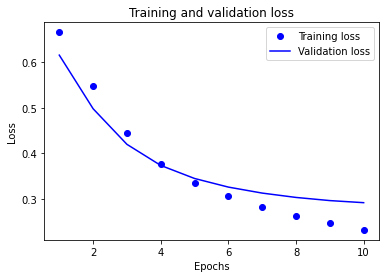

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

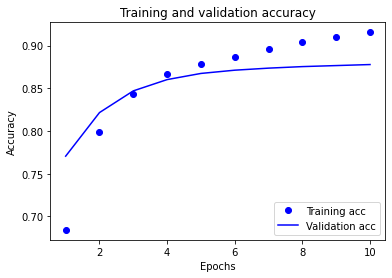

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?version=nightly).

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.3651 - accuracy: 0.8438

 11/782 [..............................] - ETA: 3s - loss: 0.2934 - accuracy: 0.8977

 21/782 [..............................] - ETA: 3s - loss: 0.2912 - accuracy: 0.8869

 31/782 [>.............................] - ETA: 3s - loss: 0.2846 - accuracy: 0.8841

 41/782 [>.............................] - ETA: 3s - loss: 0.2927 - accuracy: 0.8803

 51/782 [>.............................] - ETA: 3s - loss: 0.3006 - accuracy: 0.8775

 61/782 [=>............................] - ETA: 3s - loss: 0.3086 - accuracy: 0.8750

 71/782 [=>............................] - ETA: 3s - loss: 0.3097 - accuracy: 0.8759

 81/782 [==>...........................] - ETA: 3s - loss: 0.3088 - accuracy: 0.8765

 91/782 [==>...........................] - ETA: 3s - loss: 0.3133 - accuracy: 0.8723

101/782 [==>...........................] - ETA: 3s - loss: 0.3097 - accuracy: 0.8735

112/782 [===>..........................] - ETA: 3s - loss: 0.3059 - accuracy: 0.8747

122/782 [===>..........................] - ETA: 3s - loss: 0.3058 - accuracy: 0.8750

132/782 [====>.........................] - ETA: 3s - loss: 0.3017 - accuracy: 0.8769

142/782 [====>.........................] - ETA: 3s - loss: 0.3062 - accuracy: 0.8724

152/782 [====>.........................] - ETA: 3s - loss: 0.3078 - accuracy: 0.8719

162/782 [=====>........................] - ETA: 3s - loss: 0.3063 - accuracy: 0.8731

172/782 [=====>........................] - ETA: 3s - loss: 0.3061 - accuracy: 0.8726

182/782 [=====>........................] - ETA: 3s - loss: 0.3067 - accuracy: 0.8723

192/782 [======>.......................] - ETA: 3s - loss: 0.3081 - accuracy: 0.8714

202/782 [======>.......................] - ETA: 2s - loss: 0.3078 - accuracy: 0.8727

212/782 [=======>......................] - ETA: 2s - loss: 0.3083 - accuracy: 0.8729

222/782 [=======>......................] - ETA: 2s - loss: 0.3095 - accuracy: 0.8722

232/782 [=======>......................] - ETA: 2s - loss: 0.3084 - accuracy: 0.8728

242/782 [========>.....................] - ETA: 2s - loss: 0.3089 - accuracy: 0.8720

252/782 [========>.....................] - ETA: 2s - loss: 0.3084 - accuracy: 0.8719

262/782 [=========>....................] - ETA: 2s - loss: 0.3090 - accuracy: 0.8717

272/782 [=========>....................] - ETA: 2s - loss: 0.3089 - accuracy: 0.8725

282/782 [=========>....................] - ETA: 2s - loss: 0.3080 - accuracy: 0.8733

292/782 [==========>...................] - ETA: 2s - loss: 0.3072 - accuracy: 0.8738

302/782 [==========>...................] - ETA: 2s - loss: 0.3083 - accuracy: 0.8732

312/782 [==========>...................] - ETA: 2s - loss: 0.3077 - accuracy: 0.8734

322/782 [===========>..................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8734

332/782 [===========>..................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8740

342/782 [============>.................] - ETA: 2s - loss: 0.3083 - accuracy: 0.8736

352/782 [============>.................] - ETA: 2s - loss: 0.3085 - accuracy: 0.8736

362/782 [============>.................] - ETA: 2s - loss: 0.3090 - accuracy: 0.8731

372/782 [=============>................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8732

382/782 [=============>................] - ETA: 2s - loss: 0.3093 - accuracy: 0.8728

392/782 [==============>...............] - ETA: 2s - loss: 0.3102 - accuracy: 0.8723

402/782 [==============>...............] - ETA: 1s - loss: 0.3103 - accuracy: 0.8724

412/782 [==============>...............] - ETA: 1s - loss: 0.3105 - accuracy: 0.8723

422/782 [===============>..............] - ETA: 1s - loss: 0.3102 - accuracy: 0.8724

432/782 [===============>..............] - ETA: 1s - loss: 0.3089 - accuracy: 0.8730

442/782 [===============>..............] - ETA: 1s - loss: 0.3086 - accuracy: 0.8731

452/782 [================>.............] - ETA: 1s - loss: 0.3083 - accuracy: 0.8733

462/782 [================>.............] - ETA: 1s - loss: 0.3089 - accuracy: 0.8730

472/782 [=================>............] - ETA: 1s - loss: 0.3080 - accuracy: 0.8737

482/782 [=================>............] - ETA: 1s - loss: 0.3079 - accuracy: 0.8738

492/782 [=================>............] - ETA: 1s - loss: 0.3072 - accuracy: 0.8742

502/782 [==================>...........] - ETA: 1s - loss: 0.3069 - accuracy: 0.8743

512/782 [==================>...........] - ETA: 1s - loss: 0.3070 - accuracy: 0.8740

522/782 [===================>..........] - ETA: 1s - loss: 0.3079 - accuracy: 0.8735

532/782 [===================>..........] - ETA: 1s - loss: 0.3075 - accuracy: 0.8740

542/782 [===================>..........] - ETA: 1s - loss: 0.3079 - accuracy: 0.8740

552/782 [====================>.........] - ETA: 1s - loss: 0.3079 - accuracy: 0.8738

562/782 [====================>.........] - ETA: 1s - loss: 0.3084 - accuracy: 0.8734

572/782 [====================>.........] - ETA: 1s - loss: 0.3095 - accuracy: 0.8729

582/782 [=====================>........] - ETA: 1s - loss: 0.3103 - accuracy: 0.8726

592/782 [=====================>........] - ETA: 0s - loss: 0.3104 - accuracy: 0.8720

602/782 [======================>.......] - ETA: 0s - loss: 0.3095 - accuracy: 0.8728

612/782 [======================>.......] - ETA: 0s - loss: 0.3100 - accuracy: 0.8727

621/782 [======================>.......] - ETA: 0s - loss: 0.3104 - accuracy: 0.8727

630/782 [=======================>......] - ETA: 0s - loss: 0.3114 - accuracy: 0.8721

640/782 [=======================>......] - ETA: 0s - loss: 0.3119 - accuracy: 0.8720

650/782 [=======================>......] - ETA: 0s - loss: 0.3119 - accuracy: 0.8718

660/782 [========================>.....] - ETA: 0s - loss: 0.3127 - accuracy: 0.8714

670/782 [========================>.....] - ETA: 0s - loss: 0.3129 - accuracy: 0.8715

679/782 [=========================>....] - ETA: 0s - loss: 0.3125 - accuracy: 0.8717

689/782 [=========================>....] - ETA: 0s - loss: 0.3114 - accuracy: 0.8723

699/782 [=========================>....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8724

709/782 [==========================>...] - ETA: 0s - loss: 0.3117 - accuracy: 0.8725

719/782 [==========================>...] - ETA: 0s - loss: 0.3112 - accuracy: 0.8729

729/782 [==========================>...] - ETA: 0s - loss: 0.3112 - accuracy: 0.8729

739/782 [===========================>..] - ETA: 0s - loss: 0.3112 - accuracy: 0.8727

749/782 [===========================>..] - ETA: 0s - loss: 0.3116 - accuracy: 0.8726

759/782 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8728

769/782 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8733

781/782 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8734

782/782 [==============================] - 4s 5ms/step - loss: 0.3104 - accuracy: 0.8735


0.8734800219535828


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6287589 ],
       [0.45188135],
       [0.3664309 ]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multiclass classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly). This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 

If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/en/text_classification_solution.ipynb).


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
